# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
import itertools
from io import StringIO


%matplotlib inline

# Read data

In [2]:
df = pd.read_csv("sentiment.csv", sep=';')
print(df.shape)

print(df.head())

(27731, 2)
                                                data                     title
0  রুদ্র জাহেদ ভাই খুব ভাল লাগল আপনার মন্তব্যে অন...             Love(ভালবাসা)
1  যারা ব্লগ দিয়ে ইন্টারনেট চালানোর দাবি করেছিল ২...                Like (ভাল)
2                                  থ্যাংকস সুমন ভাই।                Like (ভাল)
3                                  থ্যাংকস সুমন ভাই।                Like (ভাল)
4                              সময়ের নিষ্ঠ প্রতিবাদ।  Consciousness (চেতনাবাদ)


# Labels the data

In [3]:
col = ['title', 'data']
df = df[col]
df = df[pd.notnull(df['data'])]
df.columns = ['title', 'data']
df['category_id'] = df['title'].factorize()[0]
category_id_df = df[['title', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'title']].values)
df.head()

,title,data,category_id
0,Love(ভালবাসা),রুদ্র জাহেদ ভাই খুব ভাল লাগল আপনার মন্তব্যে অন...,0
1,Like (ভাল),যারা ব্লগ দিয়ে ইন্টারনেট চালানোর দাবি করেছিল ২...,1
2,Like (ভাল),থ্যাংকস সুমন ভাই।,1
3,Like (ভাল),থ্যাংকস সুমন ভাই।,1
4,Consciousness (চেতনাবাদ),সময়ের নিষ্ঠ প্রতিবাদ।,2


In [4]:
print('Total Comments', df.shape[0])
print('------------------------------')

print(df.groupby('title').data.count())

Total Comments 27731
------------------------------
title
Angry (রাগান্বিত)                 655
Bad (খারাপ)                       690
Blush(গোলাপী আভা)                810
Consciousness (চেতনাবাদ)          809
Evil (জঘন্য)                      390
Fail (ব্যর্থ)                     639
HaHa(হা হা)                      1636
Like (ভাল)                      11099
Love(ভালবাসা)                    1312
Protestant (প্রতিবাদমূলক)         446
Provocative (উস্কানিমুলক)         636
Rocking (আন্দোলিত হত্তয়া)       760
Sad (দু: খিত)                    1597
Shocking (অতিশয় বেদনাদায়ক)      452
Skeptical (সন্দেহপ্রবণ)           348
Skip ( বোঝতে পারছি না )          1344
Smiley (স্মাইলি)                 3014
WOW(কি দারুন)                    1094
Name: data, dtype: int64


In [5]:
df['title'] = df.title.str.replace('[(].*', '', regex=True)
outputClass = df['title'].unique()

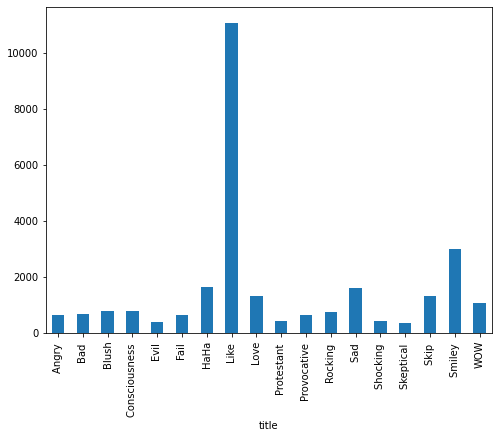

In [6]:
fig = plt.figure(figsize=(8,6))
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei', 'sans-serif']

df.groupby('title').data.count().plot.bar(ylim=0)
plt.show()

# Create tfidf using TfidfVectorizer

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.data).toarray()
labels = df.category_id
print(features.shape)

(27731, 20759)


# Print Most correlated unigrams and bigrams

In [8]:
N = 2
for newCategory, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(newCategory))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Angry (রাগান্বিত)':
  . Most correlated unigrams:
. নখ
. এইসবর
  . Most correlated bigrams:
. দন আব
. এইসবর দন
# 'Bad (খারাপ)':
  . Most correlated unigrams:
. নঅন
. রণর
  . Most correlated bigrams:
. যত বক
. বহ এখন
# 'Blush(গোলাপী আভা)':
  . Most correlated unigrams:
. আহল
. বখ
  . Most correlated bigrams:
. বয়স হয়
. যব সফ
# 'Consciousness (চেতনাবাদ)':
  . Most correlated unigrams:
. ভণ
. বধ
  . Most correlated bigrams:
. এই সচ
. রই বদন
# 'Evil (জঘন্য)':
  . Most correlated unigrams:
. ইমর
. টকশ
  . Most correlated bigrams:
. সবচ ইত
. পড় দর
# 'Fail (ব্যর্থ)':
  . Most correlated unigrams:
. সঞ
. জকন
  . Most correlated bigrams:
. মম এব
. ইছ আম
# 'HaHa(হা হা)':
  . Most correlated unigrams:
. মজ
. হরল
  . Most correlated bigrams:
. হরল হব
. জন হরল
# 'Like (ভাল)':
  . Most correlated unigrams:
. সঞ
. জয
  . Most correlated bigrams:
. যব সঞ
. সঞ জয
# 'Love(ভালবাসা)':
  . Most correlated unigrams:
. তরত
. ঝর
  . Most correlated bigrams:
. ছব চমৎক
. অট বন
# 'Protestant (প্রতিবাদমূলক)

# Define function for plotting the accuracy matrix

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('')
#         print('Confusion matrix, with little normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.show()

# Import library for spliting trainig and testing data. Calulating the accuracy

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Split training and testing data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, df['title'], test_size=0.25, random_state=42)

# MultinomialNB

In [12]:
from sklearn.naive_bayes import MultinomialNB

mnbClf = MultinomialNB()
mnbClf.fit(X_train, y_train)
mnbClf_pred = mnbClf.predict(X_test)
cm = confusion_matrix(y_test, mnbClf_pred)
# print(cm)
score = accuracy_score(y_test, mnbClf_pred)

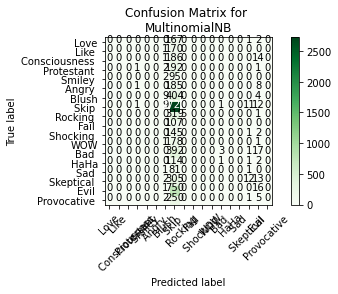

In [13]:
plot_confusion_matrix(cm, 
                      classes=outputClass, 
                      title="Confusion Matrix for \nMultinomialNB",
                      cmap = plt.cm.Greens
                     )

# LogisticRegression

In [14]:
from sklearn.linear_model import LogisticRegression
lrClf = LogisticRegression(fit_intercept=True, intercept_scaling=1, class_weight='balanced', solver='liblinear', max_iter=500)
lrClf.fit(X_train, y_train)
lrClf_pred = mnbClf.predict(X_test)
cm = confusion_matrix(y_test, lrClf_pred)
# print(cm)
accuracy_score(y_test, lrClf_pred)

0.39924996394057405

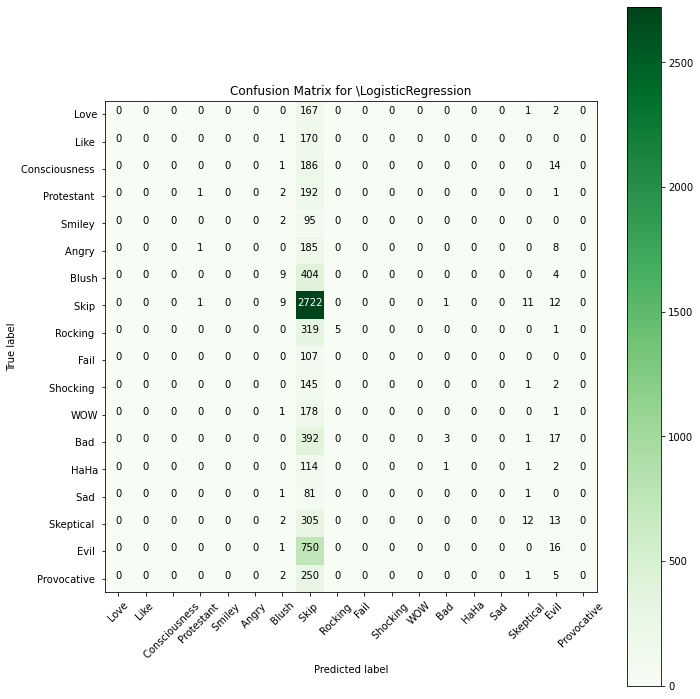

In [15]:
plot_confusion_matrix(cm, 
                      classes=outputClass, 
                      title="Confusion Matrix for \LogisticRegression",
                      cmap = plt.cm.Greens
                     )

# MLP

In [16]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(4,2,5), activation='relu', solver='adam', max_iter=1000)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(4, 2, 5), max_iter=1000)

In [17]:
mlp_pred = mlp.predict(X_test)
cm = confusion_matrix(y_test, lrClf_pred)
# print(cm)
accuracy_score(y_test, mlp_pred)

0.37285446415693063

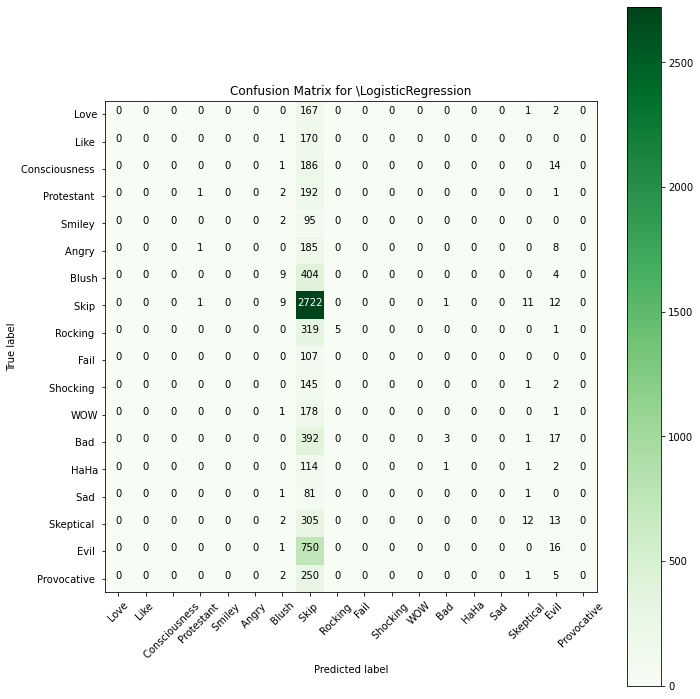

In [18]:
plot_confusion_matrix(cm, 
                      classes=outputClass, 
                      title="Confusion Matrix for \LogisticRegression",
                      cmap = plt.cm.Greens
                     )

# SVM

In [ ]:
from sklearn import svm

svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
svm_y_pred = svm_clf.predict(X_test)
cm = confusion_matrix(y_test, svm_y_pred)
# print(cm)
accuracy_score(y_test, svm_y_pred)

In [ ]:
plot_confusion_matrix(cm, 
                      classes=outputClass, 
                      title="Confusion Matrix for \svm",
                      cmap = plt.cm.Greens
                     )